In [1]:
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
from time import time
from scipy.stats import randint as sp_randint
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score, KFold, train_test_split
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC
import seaborn as sns
import xgboost as xgb
%pylab inline
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Populating the interactive namespace from numpy and matplotlib


## 1. Load Training ASM and Byte Feature Data and Combine

    Run the model selection functions on the combined ASM training data for the
    30% best feature set and call graph feature set.
    So the data frames will be:
       - final-combined-train-data-30percent.csv
       - sorted_train_labels.csv
       - all-combined-train-data.csv

In [2]:
# First load the .asm and .byte training data and training labels
# sorted_train_data_asm = pd.read_csv('data/sorted-train-malware-features-asm-reduced.csv')
# sorted_train_data_byte = pd.read_csv('data/sorted-train-malware-features-byte.csv')
sorted_train_labels = pd.read_csv('data/sorted-train-labels.csv')
combined_train_data = pd.read_csv('data/final-combined-train-data-30percent.csv')
combined_test_data = pd.read_csv('data/final-combined-test-data-30percent.csv')
call_graph_features_train = pd.read_csv('data/final-call-graph-features-10percent.csv')

In [3]:
sorted_train_labels.head()

,Id,Class
0,01IsoiSMh5gxyDYTl4CB,2
1,01SuzwMJEIXsK7A8dQbl,8
2,01azqd4InC7m9JpocGv5,9
3,01jsnpXSAlgw6aPeDxrU,9
4,01kcPWA9K2BOxQeS5Rju,1


In [4]:
combined_train_data.head()

,filename,edx,esi,es,ds,ss,cs,ah,al,ax,bh,bl,bx,ch,cl,cx,dh,dl,dx,eax,
0,01IsoiSMh5gxyDYTl4CB,750,496,3,0,0,0,8,224,49,34,25,0,41,191,52,38,163,63,1447,...
1,01SuzwMJEIXsK7A8dQbl,1121,24,3,1,4,2,6,22,7,1,4,0,3,37,2,4,9,3,1220,...
2,01azqd4InC7m9JpocGv5,1493,1900,0,0,0,0,1,398,0,0,47,0,1,77,4,1,56,2,4438,...
3,01jsnpXSAlgw6aPeDxrU,525,4,0,0,0,0,0,0,0,0,1,0,0,1,2,0,0,0,942,...
4,01kcPWA9K2BOxQeS5Rju,23,35,0,0,0,0,0,3,0,0,1,0,0,1,0,0,0,0,137,...


In [3]:
combined_test_data.head()

,filename,edx,esi,es,ds,ss,cs,ah,al,ax,...,ASM_964,ASM_972,ASM_977,ASM_990,testmean,teststd,testmin,testmax,testtotal,testlogtotal
0,ITSUPtCmh7WdJcsYDwQ5,245,434,0,1,0,0,9,51,1,...,58,48,9,32,68.566600,1160.839091,0.0,25828.0,2.055774e+09,21.443918
1,Ig2DB5tSiEy1cJvV0zdw,258,437,0,0,0,0,11,60,1,...,116,48,9,59,6.520875,63.787014,0.0,1152.0,4.791711e+05,13.079813
2,Jmo6eIhLZ4t9r8QsxEg5,238,365,0,0,0,0,8,51,0,...,48,89,32,71,143.512922,2944.234343,0.0,66084.0,2.792285e+10,24.052711
3,JtPFl4ewgdD78OzCMa3o,241,556,1,1,1,0,4,52,0,...,48,89,32,71,11.072565,137.982152,0.0,2815.0,4.300803e+06,15.274312
4,K3ZtByPHGSFYNljDUEXp,92,75,0,0,0,0,0,1,0,...,116,48,9,59,10.152087,123.150863,0.0,2491.0,3.114344e+06,14.951529


In [2]:
# Utility function to report best scores
from operator import itemgetter

def report(grid_scores, n_top=3):
  top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
  for i, score in enumerate(top_scores):
    print("Model with rank: {0}".format(i + 1))
    print("Mean validation score: {0:.3f} (std: {1:.3f})".format(score.mean_validation_score, np.std(score.cv_validation_scores)))
    print("Parameters: {0}".format(score.parameters))
    print("")

In [3]:
def run_cv(X,y, clf):

    # Construct a kfolds object
    kf = KFold(len(y),n_folds=10,shuffle=True)
    y_prob = np.zeros((len(y),9))
    y_pred = np.zeros(len(y))
    
    # Iterate through folds
    for train_index, test_index in kf:
        print(test_index, train_index)
        X_train = X.loc[train_index,:]
        X_test = X.loc[test_index,:]
        y_train = y[train_index]

        clf.fit(X_train, y_train.flatten()) # use flatten to get rid of data conversion warnings
        
        y_prob[test_index] = clf.predict_proba(X_test)
        y_pred[test_index] = clf.predict(X_test)
        #print(clf.get_params())
    
    return y_prob, y_pred

## 2. Model Selection On The ASM Features Using GridSearchCV 
      Models include:
      - GradientBoostingClassifier: randomized and grid search.
      - SVC: randomized and grid search.
      - ExtraTrees: randomized and grid search.

In [7]:
# Assign asm data to X,y for brevity, then split the dataset in two equal parts.
X = combined_train_data.iloc[:,1:]
y = np.array(sorted_train_labels.iloc[:,1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [8]:
X_train.shape

(9781, 622)

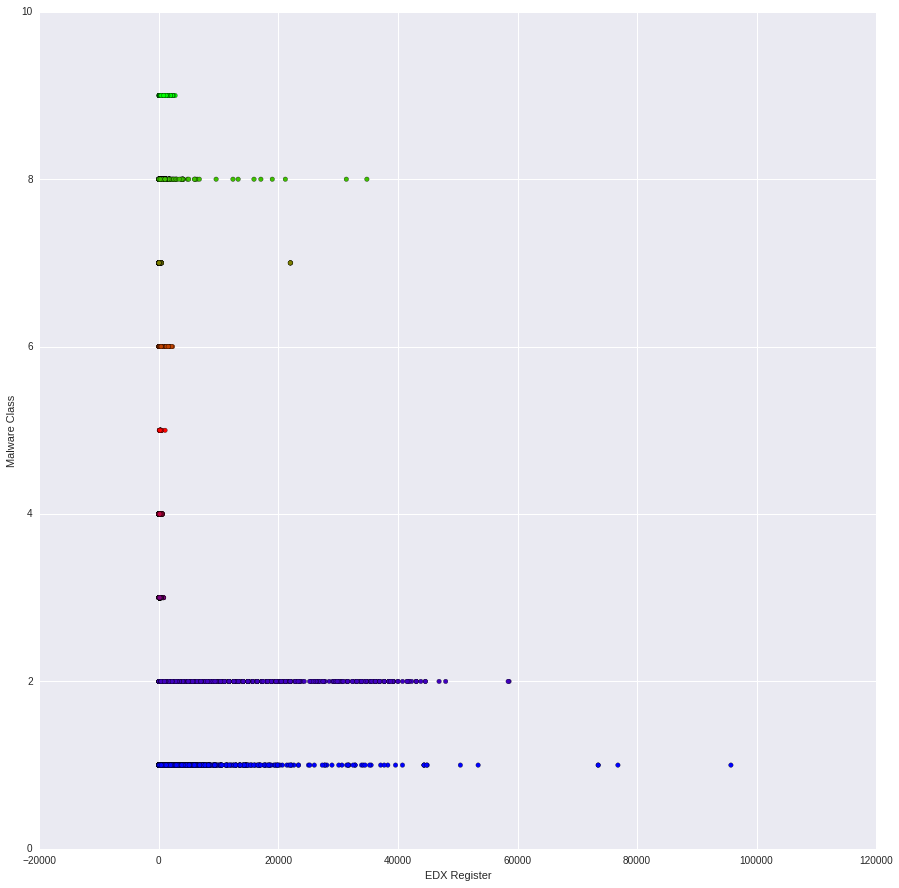

In [35]:
plt.figure(figsize=(15,15))
plt.xlabel("EDX Register")
plt.ylabel("Malware Class")
xa = np.array(X['edx'])
xb = np.array(X['esi'])
ya = np.array(y)
plt.scatter(xa,ya,c=ya,cmap='brg')

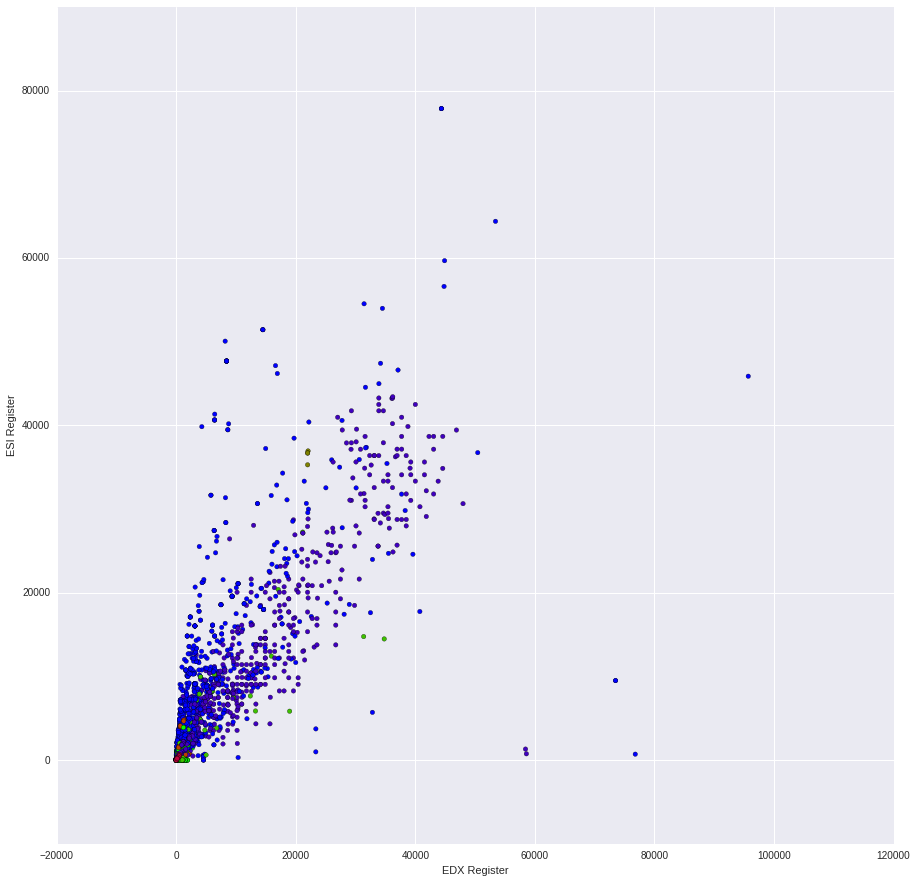

In [36]:
plt.figure(figsize=(15,15))
plt.xlabel("EDX Register")
plt.ylabel("ESI Register")
xa = np.array(X['edx'])
xb = np.array(X['esi'])
ya = np.array(y)
plt.scatter(xa,xb,c=ya,cmap='brg')

In [18]:
X_means = X.mean()
X_std = X.std()
X_var = X.var()
X_cov = X.cov()

In [19]:
X_means.head()

edx    1627.457674
esi    1949.682002
ah       13.150994
al      152.700037
ax       49.641792
dtype: float64

In [23]:
X_std.head()

edx    5068.465392
esi    5658.988444
ah       81.636518
al      553.207687
ax      253.375761
dtype: float64

In [24]:
X_var.head()

edx    25689341.427214
esi    32024150.208061
ah         6664.521139
al       306038.744467
ax        64199.276203
dtype: float64

In [25]:
X_cov.head()

,edx,esi,ah,al,ax,bl,bx,cl,cx,dl,dx,eax,ebp,ebx,ecx,edi,esp,add,al.1,call,
edx,25689341.427214,24021341.574926,77816.365966,1173060.889760,552707.732099,420122.862691,67935.903298,664336.192624,167677.530769,551986.788517,160633.380396,39635373.785218,13309252.000075,20855102.917360,28932452.694969,21103114.490023,9351810.128536,3473379.040971,540426.239710,5675087.723663,...
esi,24021341.574926,32024150.208061,117102.369544,1749134.774025,738932.665688,642582.379645,103909.215140,870052.329000,252532.083299,650535.234988,200624.604762,50748782.440052,19637851.943241,23443489.760017,34132376.322045,25966079.132978,12268049.826251,4326258.849094,798573.314783,10426088.255026,...
ah,77816.365966,117102.369544,6664.521139,15879.570373,10025.209333,5030.475764,853.997842,9236.682431,2749.135929,6430.990007,2389.313708,229611.474637,116872.495946,60487.716837,142338.161977,74460.616296,137561.086979,37961.031797,6466.934908,61301.219905,...
al,1173060.889760,1749134.774025,15879.570373,306038.744467,62467.912234,100111.288981,9909.860039,149590.112335,24356.869014,151871.916812,20967.927374,3528392.978622,1789404.646572,984825.883538,2080083.867064,1120180.196304,1301054.148815,450909.003780,141437.789580,976032.060932,...
ax,552707.732099,738932.665688,10025.209333,62467.912234,64199.276203,21323.331827,9850.954983,34519.207327,20671.689437,24800.422126,16559.973295,1402595.601515,608089.199128,469983.301482,857070.437279,527729.536491,558199.726942,182120.157051,26426.084706,326873.348816,...


### 2.1 Gradient Boosting

### 2.2 Support Vector Machine

#### 2.2.1 Randomized Search

In [ ]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

print("# Tuning hyper-parameters for SVC")
print()

clfrand = RandomizedSearchCV(SVC(C=1), tuned_parameters, cv=10)

start = time()
clfrand.fit(X_train, y_train)

print("Best parameters set found on training set:")
print()
print(clfrand.best_params_)
print()
print("Grid scores on training set:")
print()
report(clfrand.grid_scores_)    
print()
print("Classification report:")
print("SVC took {:.2f} seconds for {:d} candidates.".format(((time() - start), n_iter_search)))
print()
y_true, y_pred = y_test, clfrand.predict(X_test)
print(classification_report(y_true, y_pred))
print()

#### 2.2.2 Grid Search

In [ ]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

print("# Tuning hyper-parameters for SVC")
print()

clfgrid = GridSearchCV(SVC(C=1), tuned_parameters, cv=10, n_jobs=4)

start = time()
clfgrid.fit(X_train, y_train)

print("Best parameters set found on training set:")
print()
print(clfgrid.best_params_)
print()
print("Grid scores on training set:")
print()
report(clfgrid.grid_scores_)    
print()
print("Classification report:")
print("SVC took {:.2f} seconds for {:d} candidates.".format(((time() - start), n_iter_search)))
print()
y_true, y_pred = y_test, clfgrid.predict(X_test)
print(classification_report(y_true, y_pred))
print()

# Tuning hyper-parameters for SVC
()


### 2.3 Extra Trees Classifier

#### 2.3.1 Randomized Search

In [14]:
clfextra1 = ExtraTreesClassifier(n_jobs=4)

# use a random grid over parameters, most important parameters are n_estimators (larger is better) and
# max_features (for classification best value is square root of the number of features)
# Reference: http://scikit-learn.org/stable/modules/ensemble.html
param_dist = {"n_estimators": [100, 500, 1000],
              "max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clfextra1, param_distributions=param_dist, n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)

print("ExtraTreesClassifier - RandomizedSearchCV:")
print(" ")
print("Best parameters set found on training set:")
print(" ")
print(random_search.best_params_)
print(" ")
print("Grid scores on training set:")
print(" ")
report(random_search.grid_scores_)
print(" ")
print("Classification report:")
print("RandomizedSearchCV took {:.2f} seconds for {:d} candidates.".format((time() - start), n_iter_search))
print(" ")
y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))
print(" ")
y_prob = random_search.predict_proba(X_test)
print("logloss = {:.3f}".format(log_loss(y_test, y_prob)))
print("score = {:.3f}".format(accuracy_score(y_test, y_pred)))
cm = confusion_matrix(y_test, y_pred)
print(cm)

ExtraTreesClassifier - RandomizedSearchCV:
 
Best parameters set found on training set:
 
{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 7, 'max_depth': None}
 
Grid scores on training set:
 
Model with rank: 1
Mean validation score: 0.997 (std: 0.000)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 7, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.996 (std: 0.001)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 5, 'criterion': 'entropy', 'max_features': 6, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.994 (std: 0.001)
Parameters: {'bootstrap': False, 'min_samples_leaf': 6, 'n_estimators': 500, 'min_samples_split': 1, 'criterion': 'entropy', 'max_features': 9, 'max_depth': None}

 
Classification report:
RandomizedSearchCV took 17

#### 2.3.2 Grid Search

In [ ]:
clfextra2 = ExtraTreesClassifier(n_jobs=4)

# use a full grid over all parameters, most important parameters are n_estimators (larger is better) and
# max_features (for classification best value is square root of the number of features)
# Reference: http://scikit-learn.org/stable/modules/ensemble.html
param_grid = {"n_estimators": [100, 500, 1000, 2000],
              "max_depth": [None],
              "max_features": [20],
              "min_samples_split": [1],
              "min_samples_leaf": [1],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clfextra2, param_grid=param_grid, cv=10)
start = time()
grid_search.fit(X_train, y_train)

print("ExtraTreesClassifier - GridSearchCV:")
print(" ")
print("Best parameters set found on training set:")
print(" ")
print(grid_search.best_params_)
print(" ")
print("Grid scores on training set:")
print(" ")
report(grid_search.grid_scores_)
print(" ")
print("Classification report:")
print("GridSearchCV took {:.2f} seconds.".format((time() - start)))
print(" ")
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
print(" ")
y_prob = grid_search.predict_proba(X_test)
print("logloss = {:.3f}".format(log_loss(y_test, y_prob)))
print("score = {:.3f}".format(accuracy_score(y_train, y_pred)))
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [13]:
print("Classification report:")
print("GridSearchCV took {:.2f} seconds.".format(time() - start))
print(" ")
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
print(" ")
y_prob = grid_search.predict_proba(X_test)
print("logloss = {:.3f}".format(log_loss(y_test, y_prob)))
print("score = {:.3f}".format(accuracy_score(y_test, y_pred)))
cm = confusion_matrix(y_test, y_pred)
print(cm)

Classification report:
GridSearchCV took 2183.53 seconds.
 
             precision    recall  f1-score   support

          1       0.99      1.00      1.00       135
          2       1.00      1.00      1.00       251
          3       1.00      1.00      1.00       292
          4       1.00      1.00      1.00        45
          5       1.00      1.00      1.00         2
          6       1.00      1.00      1.00        84
          7       1.00      0.98      0.99        47
          8       0.99      1.00      1.00       127
          9       1.00      0.99      1.00       104

avg / total       1.00      1.00      1.00      1087

 
logloss = 0.014
score = 0.998
[[135   0   0   0   0   0   0   0   0]
 [  0 251   0   0   0   0   0   0   0]
 [  0   0 292   0   0   0   0   0   0]
 [  0   0   0  45   0   0   0   0   0]
 [  0   0   0   0   2   0   0   0   0]
 [  0   0   0   0   0  84   0   0   0]
 [  1   0   0   0   0   0  46   0   0]
 [  0   0   0   0   0   0   0 127   0]
 [  0   0 

## 3. Model selection On The Byte Features Using GridSearchCV
      Models include:
      - Ridge Classifier
      - SVC: grid search.
      - ExtraTrees: grid search.

In [37]:
# Assign byte data to X,y for brevity, then split the dataset in two equal parts.
X = sorted_train_data_byte.iloc[:,1:]
y = np.array(sorted_train_labels.iloc[:,1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

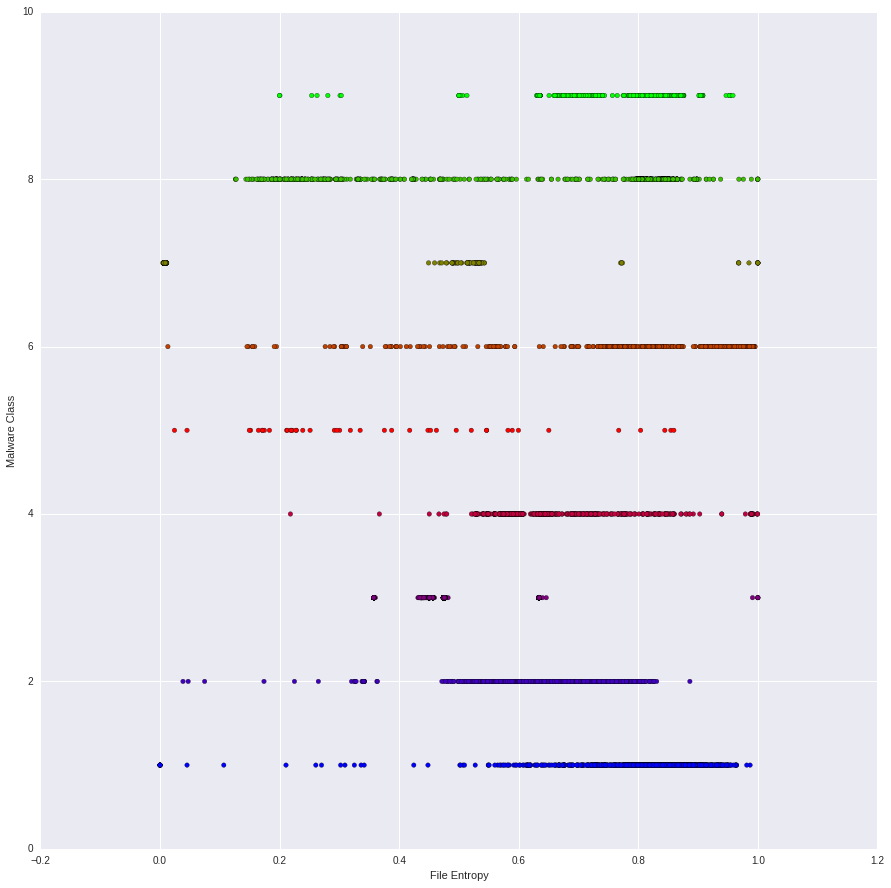

In [44]:
plt.figure(figsize=(15,15))
plt.xlabel("File Entropy")
plt.ylabel("Malware Class")
xa = np.array(X['entropy'])
xb = np.array(X['filesize'])
ya = np.array(y)
plt.scatter(xa,ya,c=ya,cmap='brg')

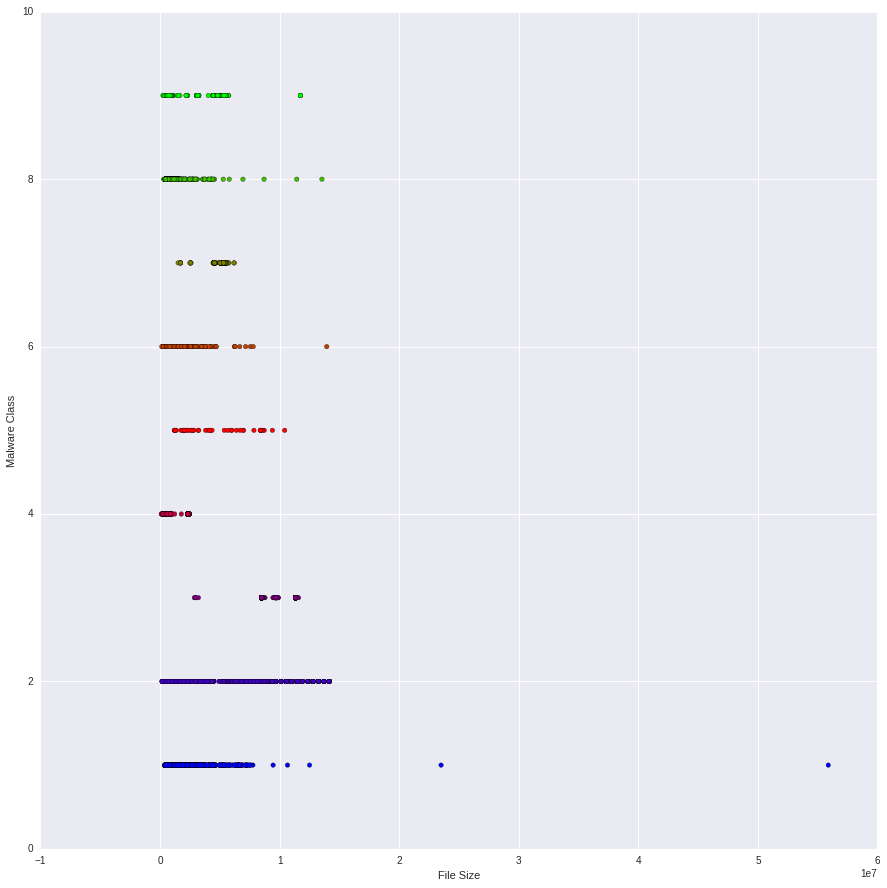

In [43]:
plt.figure(figsize=(15,15))
plt.xlabel("File Size")
plt.ylabel("Malware Class")
plt.scatter(xb,ya,c=ya,cmap='brg')

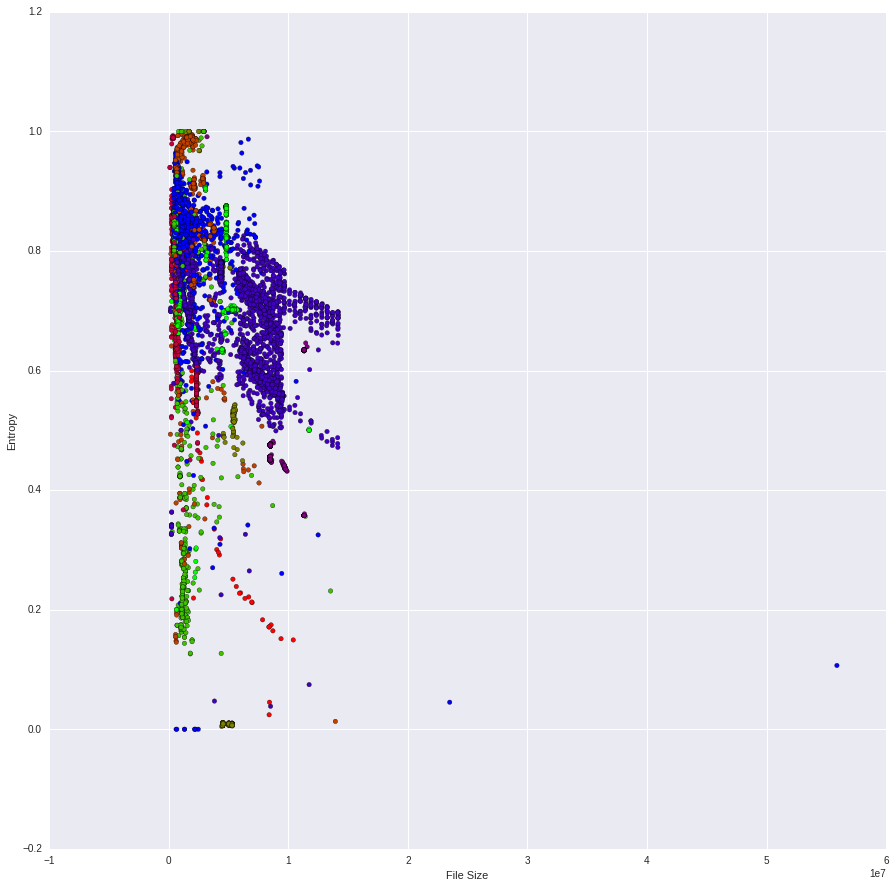

In [42]:
plt.figure(figsize=(15,15))
plt.xlabel("File Size")
plt.ylabel("Shannon's Entropy")
#colors = cm.rainbow(np.linspace(0, 1, len(ya)))
plt.scatter(xb,xa,c=ya,cmap='brg')

### 3.1 Ridge Classifier

In [ ]:
clfridge = RidgeClassifierCV(cv=10)
clfridge.fit(X_train, y_train)
y_pred = clfridge.predict(X_test)
print(classification_report(y_test, y_pred))
print(" ")
print("score = {:.3f}".format(accuracy_score(y_train, y_pred)))
cm = confusion_matrix(y_test, y_pred)
print(cm)

### 3.2 Support Vector Machine

### 3.3 Extra Trees Classifier

In [ ]:
clfextra = ExtraTreesClassifier(n_jobs=4)

# use a full grid over all parameters, most important parameters are n_estimators (larger is better) and
# max_features (for classification best value is square root of the number of features)
# Reference: http://scikit-learn.org/stable/modules/ensemble.html
param_grid = {"n_estimators": [1000, 2000],
              "max_depth": [3, None],
              "max_features": [1, 2],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clfextra, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("ExtraTreesClassifier - GridSearchCV:")
print(" ")
print("Best parameters set found on training set:")
print(" ")
print(grid_search.best_params_)
print(" ")
print("Grid scores on training set:")
print(" ")
report(grid_search.grid_scores_)
print(" ")
print("Classification report:")
print("GridSearchCV took {:.2f} seconds.".format((time() - start)))
print(" ")
y_pred = grid_search.predict(X)
print(classification_report(y, y_pred))
print(" ")
y_prob = grid_search.predict_proba(X)
print("logloss = {:.3f}".format(log_loss(y, y_prob)))
print("score = {:.3f}".format(accuracy_score(y, y_pred)))
cm = confusion_matrix(y, y_pred)
print(cm)

## 4. Model Selection On The Combined Training ASM/Byte Data Using GridSearchCV
    Grid search will be done on the following classifiers:
    - Ridge Classifier
    - ExtraTreesClassifier
    - GradientBoost
    - RandomForest
    - SVC

In [6]:
# Assign byte data to X,y for brevity, then split the dataset in two equal parts.
X = combined_train_data.iloc[:,1:]
y = np.array(sorted_train_labels.iloc[:,1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

### 4.1 Ridge Classifier

In [33]:
from sklearn.linear_model import RidgeClassifierCV

clfridge = RidgeClassifierCV(cv=10)
clfridge.fit(X_train, y_train)
y_pred = clfridge.predict(X_test)
print(classification_report(y_test, y_pred))
print(" ")
print("score = {:.3f}".format(accuracy_score(y_train, y_pred)))
cm = confusion_matrix(y_test, y_pred)
print(cm)

             precision    recall  f1-score   support

          1       0.70      0.89      0.78       744
          2       0.99      0.97      0.98      1263
          3       0.97      1.00      0.99      1472
          4       0.95      0.42      0.58       230
          5       0.00      0.00      0.00        22
          6       0.95      0.70      0.80       364
          7       0.72      0.84      0.77       194
          8       0.78      0.83      0.80       624
          9       0.95      0.87      0.91       521

avg / total       0.90      0.89      0.89      5434

 
score = 0.172
[[ 665    7   13    2    0    6    5   32   14]
 [   5 1225    1    1    0    1    4   25    1]
 [   2    0 1469    0    0    0    0    1    0]
 [  80    3    0   96    0    0    3   48    0]
 [   0    0    8    0    0    0    0   14    0]
 [  98    0    0    2    0  253    3    8    0]
 [   6    0    6    0    0    0  162   19    1]
 [  38    1    8    0    0    3   48  519    7]
 [  60    0   

### 4.2 Extra Trees Classifier

In [17]:
clf1 = ExtraTreesClassifier(n_estimators=1000, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
p1, pred1 = run_cv(X,y,clf1)
print("logloss = {:.3f}".format(log_loss(y, p1)))
print("score = {:.3f}".format(accuracy_score(y, pred1)))
cm = confusion_matrix(y, pred1)
print(cm)

(array([   38,    41,    63, ..., 10845, 10854, 10866]), array([    0,     1,     2, ..., 10864, 10865, 10867]))
(array([    1,     7,    11, ..., 10855, 10857, 10862]), array([    0,     2,     3, ..., 10865, 10866, 10867]))
(array([    8,    13,    18, ..., 10842, 10848, 10860]), array([    0,     1,     2, ..., 10865, 10866, 10867]))
(array([    3,    17,    19, ..., 10851, 10858, 10863]), array([    0,     1,     2, ..., 10865, 10866, 10867]))
(array([    4,    12,    23, ..., 10823, 10827, 10831]), array([    0,     1,     2, ..., 10865, 10866, 10867]))
(array([    2,     6,    32, ..., 10856, 10859, 10864]), array([    0,     1,     3, ..., 10865, 10866, 10867]))
(array([   10,    29,    37, ..., 10840, 10843, 10861]), array([    0,     1,     2, ..., 10865, 10866, 10867]))
(array([   16,    20,    21, ..., 10807, 10819, 10833]), array([    0,     1,     2, ..., 10865, 10866, 10867]))
(array([    0,    28,    39, ..., 10814, 10865, 10867]), array([    1,     2,     3, ..., 10863,

### 4.3 Gradient Boost

### 4.4 Random Forest

### 4.5 Support Vector Machine

### 4.6 Nearest Neighbours

### 4.7 XGBoost

In [15]:
X = combined_train_data.iloc[:,1:]
ylabels = sorted_train_labels.iloc[:,1:]
y = np.array(ylabels - 1)
y = y.flatten()
y

array([1, 7, 8, ..., 3, 3, 3], dtype=int64)

In [ ]:
xgclf = xgb.XGBClassifier(objective="multi:softprob", nthread=4)

params     = {"n_estimators": [1000, 2000],
              "max_depth": [5, 10],
              "learning_rate": [0.1, 0.05]}

# run grid search
grid_search = GridSearchCV(xgclf, param_grid=params)
start = time()
grid_search.fit(X, y)

print("XGBoost Classifier - GridSearchCV:")
print(" ")
print("Best parameters set found on training set:")
print(" ")
print(grid_search.best_params_)
print(" ")
print("Grid scores on training set:")
print(" ")
report(grid_search.grid_scores_)
print(" ")
print("Classification report:")
print("GridSearchCV took {:.2f} seconds.".format((time() - start)))
print(" ")
y_pred = grid_search.predict(X)
print(classification_report(y, y_pred))
print(" ")
y_prob = grid_search.predict_proba(X)
print("logloss = {:.3f}".format(log_loss(y, y_prob)))
print("score = {:.3f}".format(accuracy_score(y, y_pred)))
cm = confusion_matrix(y, y_pred)
print(cm)

In [18]:
print("GridSearchCV took {:.2f} seconds.".format((time() - start)))
print(" ")
y_pred = grid_search.predict(X)
print(classification_report(y, y_pred))
print(" ")
y_prob = grid_search.predict_proba(X)
print("logloss = {:.3f}".format(log_loss(y, y_prob)))
print("score = {:.3f}".format(accuracy_score(y, y_pred)))
cm = confusion_matrix(y, y_pred)
print(cm)

GridSearchCV took 6196.85 seconds.
 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1541
          1       1.00      1.00      1.00      2478
          2       1.00      1.00      1.00      2942
          3       1.00      1.00      1.00       475
          4       1.00      1.00      1.00        42
          5       1.00      1.00      1.00       751
          6       1.00      1.00      1.00       398
          7       1.00      1.00      1.00      1228
          8       1.00      1.00      1.00      1013

avg / total       1.00      1.00      1.00     10868

 
logloss = 0.000
score = 1.000
[[1541    0    0    0    0    0    0    0    0]
 [   0 2478    0    0    0    0    0    0    0]
 [   0    0 2942    0    0    0    0    0    0]
 [   0    0    0  475    0    0    0    0    0]
 [   0    0    0    0   42    0    0    0    0]
 [   0    0    0    0    0  751    0    0    0]
 [   0    0    0    0    0    0  398    0    0]
 [   0   

In [ ]:
# Now try with best parameters and 50/50 train-test split
xgclf = xgb.XGBClassifier(n_estimators=1000, max_depth=10, learning_rate=0.01,objective="multi:softprob", nthread=4)
prob1, pred1 = run_cv(X_train, y_train, xgclf)
print("logloss = {:.3f}".format(log_loss(y_train, prob1)))
print("score = {:.3f}".format(accuracy_score(y_train, pred1)))
cm = confusion_matrix(y_train, pred1)
print(cm)

In [9]:
pred2 = xgclf.predict(X_test)
prob2 = xgclf.predict_proba(X_test)
print("logloss = {:.3f}".format(log_loss(y_test, prob2)))
print("score = {:.3f}".format(accuracy_score(y_test, pred2)))
cm = confusion_matrix(y_test, pred2)
print(cm)

logloss = 2.180
score = 0.198
[[ 47 175 415   9   0  13  12  38  35]
 [115 427 602   3   1  48  16  36  15]
 [124 604 543   5   0  27   7 129  33]
 [ 28  88  94   1   1   9   2   3   4]
 [  2   8  10   2   0   0   0   0   0]
 [ 67 104 121   5   0   5   5  37  20]
 [ 33  69  69   0   0   4   3  13   3]
 [ 30 140 390   5  13   3   2  28  13]
 [ 62 101 307   2   0  10   0  19  20]]


In [10]:
xgclf = xgb.XGBClassifier(n_estimators=1000, max_depth=10, learning_rate=0.1,objective="multi:softprob", nthread=4)
prob1, pred1 = run_cv(X,y,xgclf)
print("logloss = {:.3f}".format(log_loss(y, prob1)))
print("score = {:.3f}".format(accuracy_score(y, pred1)))
cm = confusion_matrix(y, pred1)
print(cm)

[    8    24    32 ..., 10811 10832 10852] [    0     1     2 ..., 10865 10866 10867]
[    9    10    14 ..., 10836 10841 10853] [    0     1     2 ..., 10865 10866 10867]
[    5    15    18 ..., 10755 10788 10794] [    0     1     2 ..., 10865 10866 10867]
[    1     7    23 ..., 10843 10844 10846] [    0     2     3 ..., 10865 10866 10867]
[   20    60    77 ..., 10835 10864 10867] [    0     1     2 ..., 10863 10865 10866]
[   12    33    42 ..., 10858 10859 10862] [    0     1     2 ..., 10865 10866 10867]
[    0     2    13 ..., 10855 10857 10863] [    1     3     4 ..., 10865 10866 10867]
[    3    16    22 ..., 10834 10847 10861] [    0     1     2 ..., 10865 10866 10867]
[    6    11    44 ..., 10850 10856 10865] [    0     1     2 ..., 10864 10866 10867]
[    4    21    25 ..., 10854 10860 10866] [    0     1     2 ..., 10864 10865 10867]
logloss = 0.009
score = 0.998
[[1541    0    0    0    0    0    0    0    0]
 [   2 2475    0    0    0    0    0    0    1]
 [   0    0 29

## 5. Run ExtraTreeClassifiers With 10-Fold Cross Validation

In [ ]:
help(xgb)

In [ ]:
help(ExtraTreesClassifier)

In [ ]:
ytrain = np.array(y)

In [ ]:
X = data_reduced.iloc[:,1:]
X.shape

In [ ]:
clf1 = ExtraTreesClassifier(n_estimators=1000, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
p1, pred1 = run_cv(X,ytrain,clf1)
print "logloss = %.3f" % log_loss(y, p1)
print "score = %.3f" % accuracy_score(ytrain, pred1)
cm = confusion_matrix(y, pred1)
print(cm)

In [ ]:
clf2 = ExtraTreesClassifier(n_estimators=500, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
p2, pred2 = run_cv(X,ytrain,clf2)
print "logloss = %.3f" % log_loss(y, p2)
print "score = %.3f" % accuracy_score(ytrain, pred2)
cm = confusion_matrix(y, pred2)
print(cm)

In [ ]:
clf3 = ExtraTreesClassifier(n_estimators=250, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
p3, pred3 = run_cv(X,ytrain,clf3)
print "logloss = %.3f" % log_loss(y, p3)
print "score = %.3f" % accuracy_score(ytrain, pred3)
cm = confusion_matrix(y, pred3)
print(cm)

In [ ]:
clf4 = ExtraTreesClassifier(n_estimators=2000, max_features=None, min_samples_leaf=2, min_samples_split=3, n_jobs=4, criterion='gini')
p4, pred4 = run_cv(X,ytrain,clf4)
print "logloss = %.3f" % log_loss(y, p4)
print "score = %.3f" % accuracy_score(ytrain, pred4)
cm = confusion_matrix(y, pred4)
print(cm)

In [ ]:
clf5 = ExtraTreesClassifier(n_estimators=1000, n_jobs=4, criterion='gini')
p5, pred5 = run_cv(X,ytrain,clf5)
print "logloss = %.4f" % log_loss(y, p5)
print "score = %.4f" % accuracy_score(ytrain, pred5)
cm = confusion_matrix(y, pred5)
print(cm)

In [ ]:
clf6 = ExtraTreesClassifier(n_estimators=2000, n_jobs=4, criterion='gini')
p6, pred6 = run_cv(X,ytrain,clf6)
print "logloss = %.4f" % log_loss(y, p6)
print "score = %.4f" % accuracy_score(ytrain, pred6)
cm = confusion_matrix(y, pred6)
print(cm)

## 6. GridSearchCV with XGBoost on All Combined ASM and Call Graph Features.

In [4]:
data = pd.read_csv('data/all-combined-train-data-final.csv')
labels = pd.read_csv('data/sorted-train-labels.csv')
data.head(20)

,filename,edx_asm,esi,es,ds,ss,cs,ah,al,ax,...,subst_x,subst_y,unkno,unkno_x,unkno_x.1,unkno_x.2,unkno_y,unkno_y.1,unkno_y.2,wpa_hexd
0,01IsoiSMh5gxyDYTl4CB,750,496,3,0,0,0,8,224,49,...,0.0,0.0,1.0,1,0.0,0.0,1,0.0,0.0,0.0
1,01SuzwMJEIXsK7A8dQbl,1121,24,3,1,4,2,6,22,7,...,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0
2,01azqd4InC7m9JpocGv5,1493,1900,0,0,0,0,1,398,0,...,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0
3,01jsnpXSAlgw6aPeDxrU,525,4,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0
4,01kcPWA9K2BOxQeS5Rju,23,35,0,0,0,0,0,3,0,...,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0
5,02IOCvYEy8mjiuAQHax3,19,15,1,0,2,1,2,6,0,...,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0
6,02JqQ7H3yEoD8viYWlmS,337,250,8,0,0,0,3,82,1,...,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0
7,02K5GMYITj7bBoAisEmD,10182,20055,0,0,0,0,0,97,307,...,0.0,0.0,0.0,1,1.0,1.0,1,1.0,1.0,0.0
8,02MRILoE6rNhmt7FUi45,462,576,0,0,0,0,0,48,21,...,0.0,0.0,0.0,1,1.0,1.0,1,1.0,1.0,0.0
9,02mlBLHZTDFXGa7Nt6cr,141,96,2,2,1,2,6,13,0,...,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0


In [10]:
X = data.iloc[:,1:]
ylabels = labels.iloc[:,1:].values
y = np.array(ylabels - 1).flatten() # numpy arrays are unloved in many places.
y

array([1, 7, 8, ..., 3, 3, 3])

In [11]:
labels.head()

,Id,Class
0,01IsoiSMh5gxyDYTl4CB,2
1,01SuzwMJEIXsK7A8dQbl,8
2,01azqd4InC7m9JpocGv5,9
3,01jsnpXSAlgw6aPeDxrU,9
4,01kcPWA9K2BOxQeS5Rju,1


In [12]:
xgclf = xgb.XGBClassifier(objective="multi:softprob", nthread=4)

params     = {"n_estimators": [1000, 2000],
              "max_depth": [5, 10],
              "learning_rate": [0.1, 0.05]}

# run grid search
grid_search = GridSearchCV(xgclf, param_grid=params)
start = time()
grid_search.fit(X, y)

print("XGBoost Classifier - GridSearchCV:")
print(" ")
print("Best parameters set found on training set:")
print(" ")
print(grid_search.best_params_)
print(" ")
print("Grid scores on training set:")
print(" ")
report(grid_search.grid_scores_)
print(" ")
print("Classification report:")
print("GridSearchCV took {:.2f} seconds.".format((time() - start)))
print(" ")
y_pred = grid_search.predict(X)
print(classification_report(y, y_pred))
print(" ")
y_prob = grid_search.predict_proba(X)
print("logloss = {:.3f}".format(log_loss(y, y_prob)))
print("score = {:.3f}".format(accuracy_score(y, y_pred)))
cm = confusion_matrix(y, y_pred)
print(cm)

XGBoost Classifier - GridSearchCV:
 
Best parameters set found on training set:
 
{'max_depth': 5, 'n_estimators': 1000, 'learning_rate': 0.05}
 
Grid scores on training set:
 
Model with rank: 1
Mean validation score: 0.998 (std: 0.000)
Parameters: {'max_depth': 5, 'n_estimators': 1000, 'learning_rate': 0.05}

Model with rank: 2
Mean validation score: 0.998 (std: 0.000)
Parameters: {'max_depth': 5, 'n_estimators': 2000, 'learning_rate': 0.05}

Model with rank: 3
Mean validation score: 0.998 (std: 0.000)
Parameters: {'max_depth': 5, 'n_estimators': 1000, 'learning_rate': 0.1}

 
Classification report:
GridSearchCV took 17525.74 seconds.
 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1541
          1       1.00      1.00      1.00      2478
          2       1.00      1.00      1.00      2942
          3       1.00      1.00      1.00       475
          4       1.00      1.00      1.00        42
          5       1.00      1.00  

## 7. Summary Of Results

In [ ]:
# TODO:

## 8. Test/Experimental Code Only

In [ ]:
# go through the features and delete any that sum to less than 200
colsum = X.sum(axis=0, numeric_only=True)

In [ ]:
zerocols = colsum[(colsum[:] == 0)]
zerocols

In [ ]:
zerocols = colsum[(colsum[:] < 110)]
zerocols.shape

In [ ]:
reduceX = X
for col in reduceX.columns:
  if sum(reduceX[col]) < 100:
    del reduceX[col]
    
reduceX.shape

In [ ]:
skb = SelectKBest(chi2, k=20)
X_kbestnew = skb.fit_transform(X, y)
X_kbestnew.shape

In [ ]:
combined_train_data.loc[combined_train_data['filename'] == '4jKA1GUDv6TMNpPuIxER',:]
# Get an array of labels in the same order as the asm filenames
# y = [0]*labels.shape[0]
# fnames = train_data_asm['filename']
# for i in range(len(y)):
#  fname = train_data_asm.loc[i,'filename']
#  row = labels[labels['Id'] == fname]
#  y[i] = row.iloc[0,1]

In [ ]:
train_data_byte[train_data_byte.loc[:,'filename']=='4jKA1GUDv6TMNpPuIxER']

In [ ]:
count = 0
for i in range(len(y)):
  if y[i] == 0:
    count += 1
    
print(count)

In [ ]:
count = 0
for i in range(len(sorted_train_labels)):
  if sorted_train_labels.iloc[i,1] == 0:
    count += 1
    
print(count)

In [27]:
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# get some data
digits = load_digits()
X, y = digits.data, digits.target

In [32]:
type(X)

numpy.ndarray